__`Step 1`__ Import Neccesary libraries

# Hyperparameter Tunning

__`Group Number:`__ 

**10**

__`Group Members`__ 

|STUDENT NAME|STUDENT NUMBER|EMAIL|
|---|---|---|
|Ianis Rușitoru|20220620|20220620@novaims.unl.pt|
|Ricardo Almeida|20220584|20220584@novaims.unl.pt|
|Nichita Zamisnii|20220617|20220617@novaims.unl.pt|
|Pedro Paris|20191217|20191217@novaims.unl.pt|


__`Links`__   

[Github Data Source](https://github.com/garythung/trashnet)

[Google Drive Project Folder](https://drive.google.com/drive/folders/1KfXat-zOA1sJ-0m4-4yhEesj48KawVAj)

__`Summary`__ 

-Step 1 to 5: Import packages, data, define functions <br>
-Step 6: Define wrapper function for the Keras API <br>
-Step 7: Define tuner <br>
-Step 8: Perform search <br>
-Step 9: Assesment <br>

__`Findings`__
- We have perfomed hyperparameter tunning but since we wanted to perform a fair comparison we were limit in the ammount of paramaters we could explore given the waiting time and runtime issues
- The resulting parameters marginally improved accuracy on test but we opted to keep our original model since it had lower test loss.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import datasets
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
#!pip install keras-tuner
import kerastuner as kt



__`Step 2`__ Define the connection strings

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/W5/"
main_folder, training_folder, testing_folder = "reduced_dataset/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'reduced_dataset.zip', 'reduced_dataset.zip')
    # Extract files
    zip_ = zipfile.ZipFile('reduced_dataset.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 1.097 seconds


__`Step 3`__ Define a list of parameters for the ``image_dataset_from_directory``.

In [ ]:
image_size=(256, 256)
color_mode='rgb'
batch_size=32
label_mode="categorical"
validation_split=0.15
shuffle=True
seed=0
crop_to_aspect_ratio=True
input_shape = (*image_size, 3)

__`Step 4`__ Load the data using ``image_dataset_from_directory``


In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 2028 files belonging to 5 classes.
Using 1724 files for training.
Using 304 files for validation.
Found 362 files belonging to 5 classes.


__`Step 5`__ Define plotting and assesment functions

In [ ]:
def learning_curves(baseline_history, candidate_history):
    df_baseline = pd.DataFrame.from_dict(baseline_history.history)
    df_baseline["Epoch"] = np.arange(1, len(df_baseline) + 1, 1)
    df_candidate = pd.DataFrame.from_dict(candidate_history.history)
    df_candidate["Epoch"] = np.arange(1, len(df_candidate) + 1, 1)

    # Plot baseline model
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    secondary_y = ["accuracy", "val_accuracy"]
    ax = df_baseline.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[0], grid=True, legend=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Current Baseline Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
    ax.legend(loc=(0, -0.45), framealpha=1.0)

    # Set y-axis limit for accuracy plot on the right
    max_accuracy = df_baseline['accuracy'].max()
    ax.right_ax.set_ylim([0, max_accuracy + 0.1])

    # Plot candidate model
    ax = df_candidate.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[1], grid=True, legend=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Candidate Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
    ax.legend(loc=(0, -0.45), framealpha=1.0)

    # Set y-axis limit for accuracy plot on the right
    max_accuracy = df_candidate['accuracy'].max()
    ax.right_ax.set_ylim([0, max_accuracy + 0.1])

    fig.subplots_adjust(wspace=0.3) # Increase horizontal space between subplots

    plt.show()



def compare_models(model1, model2, test_data):
  results1 = model1.evaluate(test_data)
  results2 = model2.evaluate(test_data)
    
  print("Current Baseline Model")
  print(f"Test loss: {results1[0]:.4f}")
  print(f"Test accuracy: {results1[1]:.4f}")
    
  print("\nContender Model")
  print(f"Test loss: {results2[0]:.4f}")
  print(f"Test accuracy: {results2[1]:.4f}")


def get_checkpoint_callback(model_name):
    # Define the checkpoint filepath
    checkpoint_filepath = f'best_weights_{model_name}.h5'

    # Create the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    return checkpoint_callback, checkpoint_filepath

__`Step 5`__ Define augmentation pipeline

In [ ]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.15), 
                           layers.RandomZoom(height_factor=0.15, width_factor=0.1),
                           layers.RandomBrightness(factor=0.15),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

__`Step 6`__ Define create_cnn and wrapper function for the Keras API <br><br>
Note: Although the 'filters' have the same value on every combination we wanted to make the function more customizable. We are aware that we could have defined them directly in the function. Defining different dropout rates for each droput layer was a possibility as well but we decided to go with simplicty and use the same value for both.<br><br> To ensure a fair comparison between models it is crucial to keep the same ammount of training epochs as for the previous models. We have thus agreed to not use a large ammount of variables given the training time. Moreover the Google Colab resource runtime limit can become an issue and can intrerupt the search. <br>

<br>
In this particular search there are 12 possible combinations

In [ ]:
#!pip install keras-tuner

def create_cnn_wrapper(input_shape, n_outputs=5, loss="categorical_crossentropy", metrics_=["accuracy"], seed=0):
    
    def create_cnn(hp):
        filters1 = hp.Choice('filters1', values=[32])
        filters2 = hp.Choice('filters2', values=[64])
        filters3 = hp.Choice('filters3', values=[128])
        filters4 = hp.Choice('filters4', values=[256])
        dense_units = hp.Int('dense_units', min_value=128, max_value=256, step=128)
        learning_rates = [0.0001, 0.00005]
        dropout_rate = hp.Float('dropout_rate', min_value=0.20, max_value=0.30, step=0.05)

        # Create a sequential model
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
        model.add(augmentation),
        # Convolutional layers
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(filters=filters1, kernel_size=(11, 11), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(filters=filters2, kernel_size=(5, 5), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(filters=filters3, kernel_size=(3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(filters=filters4, kernel_size=(3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Flatten())
        # Dense layers
        model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(units=n_outputs))
        
        # Compile the model before the return
        lr =  hp.Choice('learning_rate', values=learning_rates)
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

        return model
    
    return create_cnn

In [ ]:
# Define parameters for the wrapper function
input_shape = (256, 256, 3)
seed = 0

hypermodel = create_cnn_wrapper(input_shape, seed=seed)

__`Step 6`__ Since for the previos models we saved the weights best weights according to validation loss. <br>
Given this information our objective is to minimize validation loss

In [ ]:
# Create an instance of tuner
tuner = kt.RandomSearch(hypermodel, 
                        objective='val_loss', # The direction of the optimization will be inferred (min in this case)
                        directory="my_first_keras_tuner",
                        overwrite=True,                        
                        executions_per_trial=1, 
                        max_trials=15,
                        seed=seed)

In [ ]:
__`Step 7`__ Perform search

In [ ]:
tuner.search(ds_train, 
             epochs=100,
             validation_data=ds_val)

Trial 8 Complete [00h 18m 36s]
val_loss: 0.5670372843742371

Best val_loss So Far: 0.5092479586601257
Total elapsed time: 02h 25m 13s


Printing the best hyperparameters found: <br>
Overall there are two hyperparamters changes that will yield a better performance
- dropout_rate from 0.25 to 0.20
- dense_units from 128 to 258


<br> <br>Note: There might be better values for filters but we did not specify variations in the search

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best learning_rate:', best_hyperparameters.get('learning_rate'))
print('Best filters1:', best_hyperparameters.get('filters1'))
print('Best filters2:', best_hyperparameters.get('filters2'))
print('Best filters3:', best_hyperparameters.get('filters3'))
print('Best filters4:', best_hyperparameters.get('filters4'))
print('Best dense_units:', best_hyperparameters.get('dense_units'))
print('Best dropout_rate:', best_hyperparameters.get('dropout_rate'))

Best learning rate: 0.0001
Best dropout rate: 32
Best dropout rate: 64
Best dropout rate: 128
Best dropout rate: 256
Best dropout rate: 256
Best dropout rate: 0.2


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (None, 256, 256, 3)      0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 246, 246, 32)      11648     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 64)      51264     
                                                        

__`Step 9`__ To make a fair comparison we will train cnn7 which is our champion handcrafted model and cnn8 which is the candidate hyperparamter tuned model obtained from the search. We will then compare the learning curves and the test performance

In [ ]:
cnn7 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, (11, 11), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5)
])


cnn7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


callback7, filepath7 = get_checkpoint_callback('model7')
history7 = cnn7.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback7])
cnn7.load_weights(filepath7)

Epoch 1/100
54/54 [==============================] - 14s 190ms/step - loss: 1.4900 - accuracy: 0.3376 - val_loss: 1.8492 - val_accuracy: 0.4013
Epoch 2/100
54/54 [==============================] - 10s 189ms/step - loss: 1.3539 - accuracy: 0.4258 - val_loss: 1.4753 - val_accuracy: 0.4441
Epoch 3/100
54/54 [==============================] - 11s 192ms/step - loss: 1.2856 - accuracy: 0.4936 - val_loss: 1.2364 - val_accuracy: 0.4967
Epoch 4/100
54/54 [==============================] - 12s 207ms/step - loss: 1.2442 - accuracy: 0.5029 - val_loss: 1.2340 - val_accuracy: 0.5230
Epoch 5/100
54/54 [==============================] - 10s 182ms/step - loss: 1.1836 - accuracy: 0.5296 - val_loss: 1.1114 - val_accuracy: 0.5757
Epoch 6/100
54/54 [==============================] - 10s 181ms/step - loss: 1.1653 - accuracy: 0.5429 - val_loss: 1.1241 - val_accuracy: 0.5724
Epoch 7/100
54/54 [==============================] - 10s 184ms/step - loss: 1.1475 - accuracy: 0.5510 - val_loss: 1.0285 - val_accuracy:

In [ ]:
cnn8 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, (11, 11), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # tweaked based on tunning 
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # tweaked based on tunning 
    layers.Dropout(0.2), # tweaked based on tunning 
    layers.Dense(5)
])


cnn8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


callback8, filepath8 = get_checkpoint_callback('model8')
history8 = cnn8.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback8])
cnn8.load_weights(filepath8)

Epoch 1/100
54/54 [==============================] - 14s 187ms/step - loss: 1.4655 - accuracy: 0.3492 - val_loss: 1.6142 - val_accuracy: 0.4342
Epoch 2/100
54/54 [==============================] - 10s 185ms/step - loss: 1.3230 - accuracy: 0.4681 - val_loss: 1.4061 - val_accuracy: 0.4671
Epoch 3/100
54/54 [==============================] - 10s 190ms/step - loss: 1.2392 - accuracy: 0.5006 - val_loss: 1.3512 - val_accuracy: 0.4803
Epoch 4/100
54/54 [==============================] - 11s 198ms/step - loss: 1.2212 - accuracy: 0.5209 - val_loss: 1.2085 - val_accuracy: 0.5197
Epoch 5/100
54/54 [==============================] - 11s 185ms/step - loss: 1.1667 - accuracy: 0.5325 - val_loss: 1.1013 - val_accuracy: 0.5526
Epoch 6/100
54/54 [==============================] - 10s 182ms/step - loss: 1.1056 - accuracy: 0.5829 - val_loss: 1.0559 - val_accuracy: 0.5757
Epoch 7/100
54/54 [==============================] - 10s 185ms/step - loss: 1.0690 - accuracy: 0.5864 - val_loss: 1.0191 - val_accuracy:

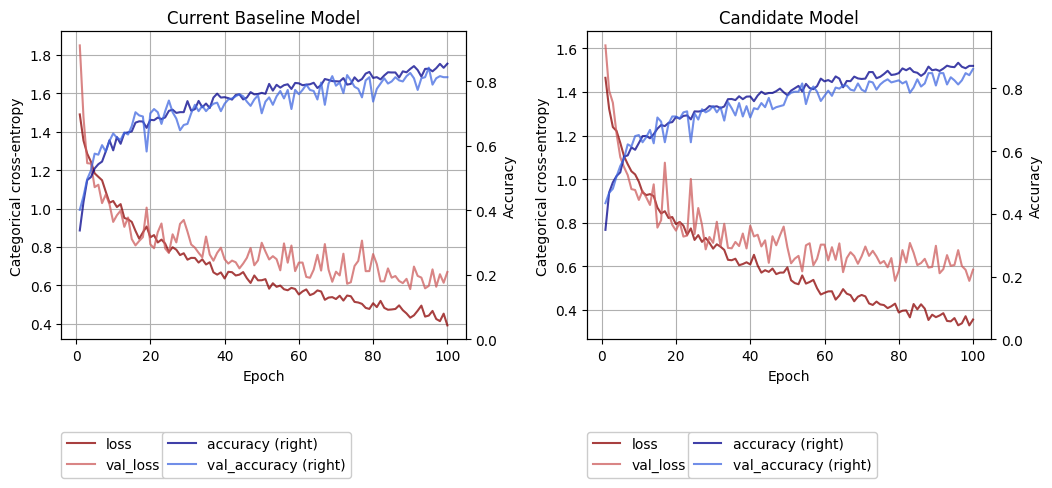

In [ ]:
learning_curves(history7, history8)

In [ ]:
compare_models(cnn7, cnn8, ds_test)

12/12 [==============================] - 1s 39ms/step - loss: 0.7101 - accuracy: 0.8011
Current Baseline Model
Test loss: 0.6477
Test accuracy: 0.7928

Contender Model
Test loss: 0.7101
Test accuracy: 0.8011


__`Assement`__ While the accuracy on test is better on the tuned model, the loss is significantly higher which translates in a lower ability to generalize. We can also observe on the learning curves that the candidate model is likelier to overfit, probably because of the increased complexity added by the doubling of the dense layer and the decreasing of the dropout rate.

__`Conclusion`__ cnn7 still stands as the best model and a more complex search should be tried to improve it